In [53]:
import radvel
import numpy as np
import rebound as rb
import matplotlib.pyplot as plt
import celmech as cm
import pandas as pd
import h5py

Set up model using $K_1$, $\frac{m_2}{m_1}$, $e_1$, $\omega_1$, $\dot{\omega}$, $P_1$, $\lambda_1$ or $M_1$:

In [54]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep = ';')
hd_data.BJD -= 2.4e6

cluster_data = h5py.File('hd_mcmc_cluster.h5', 'r')  # import the posterior distribution data from the cluster
accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted']), np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

n_burn_in = 200  # discard the first 200 samples as burn-in time
# reshape the chain to flatten it out
flat_samples = samples[n_burn_in:].reshape(-1, samples[n_burn_in:].shape[-1])

Model -- use RV model in equilibrium. First find the constant $c$ in $\frac{e_1}{e_2} = c \times \frac{m2}{m1}$, using the `REBOUNDx` eccentricity track simulations:

In [55]:
nsims = 100
Ks_orig = np.logspace(0, 5, nsims)
ecc_sims_location = 'hd_max_mass'
# initialize c array
cs = np.zeros(len(Ks_orig))

for i in range(0, len(Ks_orig)):
    ecc_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = ecc_sim.particles[1]
    outer = ecc_sim.particles[2]
    # print(inner.m, outer.m)
    cs[i] = (inner.e * inner.m)/(outer.e * outer.m)  # compute c by rearranging

In [56]:
np.median(cs)

0.9067963293569362

(array([ 1.,  4.,  2.,  3.,  2.,  3., 10., 29., 31., 15.]),
 array([0.19111961, 0.28128896, 0.37145831, 0.46162766, 0.55179701,
        0.64196636, 0.73213571, 0.82230506, 0.91247441, 1.00264376,
        1.09281311]),
 <BarContainer object of 10 artists>)

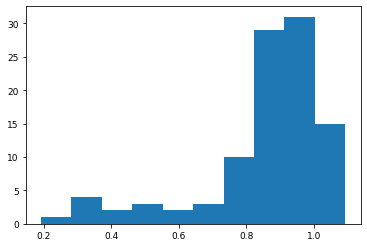

In [57]:
plt.hist(cs)

Create rv

In [58]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim

Parameters ($K_1, \frac{m_2}{m_1}, e_1, \omega_1, \dot\omega, P_1, \lambda_1$ or $M_1$):

In [59]:
test_samp = flat_samples[0]

In [64]:
# test parameters
time_base = np.median(hd_data.BJD)
fit_sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = time_base)
# 7 parameters
k1 = test_samp[1]/AUDAY_MS  # k1
e1 = test_samp[3] ** 2 + test_samp[4] ** 2  # e1
p1 = test_samp[0]  # p1
Tprecess = 50 * p1
m2_m1 = fit_sim.particles[2].m/fit_sim.particles[1].m
omega1 = np.arctan2(test_samp[3], test_samp[4])
# use from the precessingrvsignal notebook
omegadot = 2 * np.pi /Tprecess  # omegadot = omegadot1 = omegadot2
tp1 = radvel.orbit.timetrans_to_timeperi(test_samp[2], per = p1, ecc = e1, omega = omega1)
# and the constant c, using the median as the constant
c = np.median(cs)

# compute tihngs needed

# compute m1 from K1 and e1 using semiamp_to_mass
m1 = semiamp_to_mass(semiamp = k1, star_mass = STAR_MASS, period = p1, eccentricity = e1, inclination = np.pi/2)
# compute m2 using m1 and m2/m1 as a parameter
m2 = m2_m1 * m1
# compute e2 using e1, m1, m2
e2 = (e1 * m1)/(c * m2)
# compute p2 usng omegadot, since thetadot1 = thetadot2 = 0
p2 = (3 * np.pi * p1)/(2 * np.pi + p1 * omegadot)  # rearrange the equation
# compute K2 using m2, e2, and p2
k2 = mass_to_semiamp(planet_mass = m2, star_mass = STAR_MASS, period = p2, eccentricity = e2, inclination=np.pi/2)
# compute omega2 as omega1 + pi
omega2 = omega1 + np.pi


# TODO:
# convert tp to lambda, and compute lambda1 and lambda2
# also compute theta1 and 2 as well

Compare fit params and this:

In [66]:
fit_params  # p1, k1, tc1, sqrt(e1) * cos(omega1), sqrt(e1) * sin(omega1) and same for 2, plus rv offset at the end

[228.513053, 7.27743508, 53937.189, -0.178110513, -0.0466450116, 343.378023, 1
7.8603199, 54018.675, 0.13216504, 0.0973129308, -0.529039776]

In [70]:
p1, k1, e1, m1, p2, k2, e2, m2

(228.43713475691726, 4.214873375743303e-06, 0.019031577965331243, 0.2012583369
1285097, 335.9369628778195, 1.0419440027563347e-05, 0.007464629726747151, 0.56
58621620451185)

In [69]:
?get_sim_from_params

Write a function that takes in the parameters and returns a `rebound` sim from it

In [ ]:
# def rebound_to_equilibrium_params(sim, c):
#     """
#     Takes in a rebound simulation and then outputs the equilibrium parameters
    
#     """
    
    